In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sklearn.utils import shuffle
import mnist
import warnings
warnings.filterwarnings("ignore")

# 1.1 Getting Started

## Data

In [2]:
def display_image(image):
    """
    Displays an image from the mnist dataset

    Make sure you have the matplotlib library installed

    If using Jupyter, you may need to add %matplotlib inline to the top of your notebook
    """

    plt.imshow(image, cmap="gray")

In [3]:
def get_mnist_threes_nines():
    """
    Creates MNIST train / test datasets
    """

    Y0 = 3
    Y1 = 9

    y_train = mnist.train_labels()
    y_test = mnist.test_labels()
    X_train = (mnist.train_images()/255.0)
    X_test = (mnist.test_images()/255.0)
    train_idxs = np.logical_or(y_train == Y0, y_train == Y1)
    test_idxs = np.logical_or(y_test == Y0, y_test == Y1)
    y_train = y_train[train_idxs].astype('int')
    y_test = y_test[test_idxs].astype('int')
    X_train = X_train[train_idxs]
    X_test = X_test[test_idxs]
    y_train = (y_train == Y1).astype('int')
    y_test = (y_test == Y1).astype('int')
    
    return (X_train, y_train), (X_test, y_test)

In [4]:
(X_train, Y_train), (X_test, Y_test) = get_mnist_threes_nines()

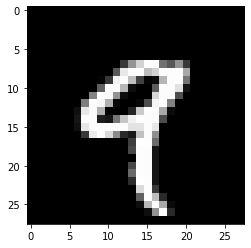

In [5]:
display_image(X_train[0])

In [6]:
# 9 is labeled as 1
Y_train[0]

1

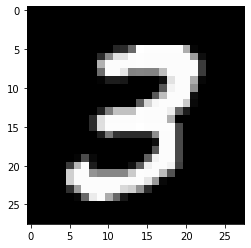

In [7]:
display_image(X_train[1])

In [8]:
# 3 is labeled as 0
Y_train[1]

0

In [9]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape

(12080, 784)

# 1. 2 Questions

## (a)

In [10]:
def finite_difference(f, a, k, epsilon=1e-5):
    """
    Computes gradients by the finite difference approximation
    
    Parameters:
    
        f: function f
        a: a d-dimensional vector 
        k: partial derivative index
        epsilon: a small constant, with 1e-5 as default value 
    
    Return Values:
    
        The partial derivative of f with respect to x_k
    """
    
    ak_plus = a.copy().astype(float)
    ak_minus = a.copy().astype(float)
    ak_plus[k] += epsilon
    ak_minus[k] -= epsilon
    
    return (f(ak_plus)-f(ak_minus))/(2*epsilon)

## (b)

In [11]:
def sigmoid_activation(a, epsilon=1e-15):
    """
    Takes in a NumPy array of arbitrary shape and applies the sigmoid function elementwise
    
    Parameters:
    
        a: a d-dimensional vector 
        epsilon: a small constant, with 1e-15 as default value
    
    Return Values:
    
        The output 
        Gradients of the sigmoid activation function
    """          
    
    output = np.where(a >= 0, 
                      1.0/(1.0+np.exp(-a)), # Positive sigmoid     
                      np.exp(a)/(1.0+np.exp(a))) # Negative sigmoid 
    
    # Sigmoid gradients: sigmoid'(x) = sigmoid(x)*(1-sigmoid(x))
    return np.clip(output, epsilon, 1-epsilon),  output*(1-output)

In [12]:
def loss_finite_difference(g, y):
    return -(y*np.log(g) + (1-y)*np.log(1-g)).mean()

In [13]:
def finite_difference_loss(y, g, k, epsilon=1e-5):
    """
    Computes the gradient of the loss by the finite difference approximation
    
    Parameters:
    
        y: a list of true labels
        g: the output of the neural network
        k: partial derivative index
        epsilon: a small constant, with 1e-5 as default value 
    
    Return Values:
    
        The gradient of the loss
    """
    
    gk_plus = g.copy().astype(float)
    gk_minus = g.copy().astype(float)
    gk_plus[k] += epsilon
    gk_minus[k] -= epsilon
    gk_plus = np.array(gk_plus)
    gk_minus = np.array(gk_minus)
    
    return (loss_finite_difference(gk_plus, y)-loss_finite_difference(gk_minus, y))/(2*epsilon)

In [14]:
def logistic_loss_finite_diff(g, y):
    """
    Computes the loss and its derivative of logistic regression using the finite difference approximation
    
    Parameters:
    
        g: the output of the neural network
        y: an array of the true labels
    
    Return Values:

        loss: loss[i] is the negative of the log-likelihood defined in lecture for binary classification
        dL_dg: the derivative of loss[i] with respect to g[i]
    """        
    
    assert g.shape == y.shape, "g and y must have the same shape"
    
    dL_dg = []
    for i in range(len(g)):
        dL_dg.append(finite_difference_loss(y, g, i, epsilon=1e-5))
        
    loss = -(y*np.log(g) + (1-y)*np.log(1-g))
    
    return loss, np.array(dL_dg)

In [15]:
def logistic_loss(g, y):
    """
    Computes the loss and its derivative of logistic regression 
    
    Parameters:
    
        g: the output of the neural network
        y: an array of the true labels
    
    Return Values:

        loss: loss[i] is the negative of the log-likelihood defined in lecture for binary classification
        dL_dg: the derivative of loss[i] with respect to g[i]
    """        
    
    assert g.shape == y.shape, "g and y must have the same shape"

    loss = -(y*np.log(g) + (1-y)*np.log(1-g))
    dL_dg = -(y/g + (y-1)*g/(1-g))/len(g)
    
    return loss, dL_dg

In [16]:
def relu_activation(s):
    '''
    Takes in an nxd array, s, and applies ReLu activation function
    
    Parameters:
    
        s: an nxd array
    
    Return Values:
    
        The elementwise activation to s
        The partial derivatives of the activation function with respect to the elements of s
    '''
            
    return np.array([np.maximum(np.zeros(len(s[i])), s[i]) for i in range(len(s))]), \
           np.array([np.where(s[i]>0, 1, 0) for i in range(len(s))])

In [17]:
def layer_forward(x, W, b, activation_fn):
    '''
    Realizes a forward layer

    Parameters:
    
        x: the nxd(l-1) dimensional matrix consisting of the mini-batch neurons for layer l-1
        W: the d(l-1)xd(l) weight matrix for layer l
        b: the 1xd(l) dimensional bias vector for layer l
        activation_fn: the activation function
    
    Return Values:
    
        out: the nxd(l) dimensional vector corresponding the mini-batch neurons for layer l
        cache: a tuple consisting of any information that we need to compute ∂l(W,b)/∂Wij and ∂l(W,b)/∂bj 
        on the backward pass
    '''
    
    out, gradients = activation_fn(np.dot(x, W) + b)
    cache = (x, W, b, gradients)
    
    return out, cache

## (c)

In [18]:
'''
These two functions return a list of weight matrices and bias vectors, respectively, 
for each layer specified in layer_dims.

They initialize the weights by sampling each weight from a normal distribution with mean 0, 
standard deviation 0.01.
'''
def create_weight_matrices(layer_dims):
    
    weights = [np.random.normal(loc=0.0, scale=0.01, size=(layer_dims[i],layer_dims[i+1])) \
               for i in range(len(layer_dims)-1)]
    
    return weights
    
def create_biases_vectors(layer_dims):
    
    biases = [np.random.normal(loc=0.0, scale=0.01, size=(1, layer_dims[i+1])) for i in range(len(layer_dims)-1)]
    
    return biases

In [19]:
def forward_pass(X_batch, weights, biases, activations):
    '''
    Takes in an nx784 dimensional minibatch of flattened images and implements forward propagation
    
    Parameters:
    
        X_batch: a minibatch of flattened images
        weights: a list of weight matrices
        biases: a list of bias vectors
        activations: a list of activation functions
    
    Return Values:
    
        output: a vector of outputs 
        cache: a list of layer caches
    '''
    
    output = X_batch
    caches = []
    
    for i in range(len(weights)):
        output, cache = layer_forward(output, weights[i], biases[i], activations[i])
        caches.append(cache)
        
    output = output.flatten()
    
    return output, caches

## (d)

In [20]:
def backward_pass(dL_dg, layer_caches):
    '''
    Calculates gradients of weights and biases to implement backward propagation
    
    Parameters:
    
        dL_dg: the derivative of loss with respect to g
        layer_caches: a list consisting of any information that we need to compute ∂l(W,b)/∂Wij and ∂l(W,b)/∂bj 
        on the backward pass
    
    Return Values:
    
        dW: a list of weights gradients
        db: a list of biases gradients
    '''
    
    delta = dL_dg.reshape(len(dL_dg), -1)
    dW = []
    db = []
    
    for i in range(len(layer_caches)-1, -1, -1):
        x, W, b, gradients = layer_caches[i]
        delta = delta*gradients
        dW.insert(0, np.dot(x.T, delta))
        db.insert(0, np.sum(delta, axis=0))
        delta = np.dot(delta, W.T)
        delta = delta.reshape(x.shape)
        
    return dW, db

## (e)

In [21]:
# Neural network parameters
layer_dims = [784, 200, 1]
activations = [relu_activation, sigmoid_activation]
weights = create_weight_matrices(layer_dims)
biases = create_biases_vectors(layer_dims)
batch_size = 100
step_size = 0.1
epochs = 5

In [22]:
def update_weights(weights, biases, dW, db, step_size=0.1):
    '''
    Updates weights and biases based on gradients
    
    Parameters:

        weights: a list of weight matrices
        biases: a list of bias vectors
        dW: a list of weights gradients
        db: a list of biases gradients
        step_size: step size, set 0.1 as default value 
    
    Return Values:
    
        weights: updated weights
        biases: updated biases
    '''
    
    for i in range(len(dW)):
        weights[i] -= step_size*dW[i]
        biases[i] -= step_size*db[i]
        
    return weights, biases

In [23]:
def calculate_accuracy(predictions, labels):
    '''
    Computes the accuracy of predictions 
    
    Parameters:

        predictions: a list of possibilities of predicted labels
        labels: a list of true labels

    Return Values:
    
        accuracy: the accuracy of predictions 
    ''' 
    
    predictions = np.where(predictions >= 0.5, 1, 0)
    accuracy = sum(np.where(predictions==labels, 1, 0))/len(labels)
    
    return accuracy

In [24]:
def SGD(X_train, Y_train, X_test, Y_test, activations, layer_dims, batch_size=100, step_size=0.1, epochs=5):
    '''
    Implements stochastic gradient descent (SGD)
    
    Parameters:

        X_train: a list of weight matrices
        Y_train: a list of bias vectors
        X_test: a list of weights gradients
        Y_test: a list of biases gradients
        activations: a list of activation functions
        layer_dims: a list of dimensions of layers 
        batch_size: size of the minibatch, set 100 as default value 
        step_size: step size, set 0.1 as default value 
        epochs: number of epochs, set 5 as default value 
    
    Return Values:
    
        training_loss: a list of training loss
        training_accuracy: a list of training accuracy
        test_loss: a list of test loss
        test_accuracy: a list of test accuracy
        output: final predictions
    '''
    
    weights = create_weight_matrices(layer_dims)
    biases = create_biases_vectors(layer_dims)
    training_loss, training_accuracy = [], []
    test_loss, test_accuracy = [], []
    
    for epoch in range(epochs):
        X_batch, Y_batch = shuffle(X_train, Y_train)
        for i in range(0, X_train.shape[0], batch_size):
            
            # Divide minibatch
            X_mini_batch = X_batch[i:i+batch_size]
            Y_mini_batch = Y_batch[i:i+batch_size]
            
            # Forward propagation
            output, caches = forward_pass(X_mini_batch, weights, biases, activations)
            loss, dL_dg = logistic_loss(output, Y_mini_batch)
            training_loss.append(np.mean(loss))
            training_accuracy.append(calculate_accuracy(output, Y_mini_batch))
            
            # Backward propagation
            dW, db = backward_pass(dL_dg, caches)
            weights, biases = update_weights(weights, biases, dW, db, step_size)
            output, caches = forward_pass(X_test, weights, biases, activations)
            loss, caches = logistic_loss(output, Y_test)
            test_loss.append(np.mean(loss))
            test_accuracy.append(calculate_accuracy(output, Y_test))
            
    return training_loss, training_accuracy, test_loss, test_accuracy, output

In [25]:
training_loss, training_accuracy, test_loss, test_accuracy, output = \
SGD(X_train, Y_train, X_test, Y_test, activations, layer_dims, batch_size, step_size, epochs)

# 1.3 Deliverables

## (a)

In [26]:
def my_nn_finite_difference_checker(X_batch, y_batch, weight_matrices, biases, activations):
    
    output, layer_caches = forward_pass(X_batch, weight_matrices, biases, activations)
    # Computes dL_dg using the finite difference approximation
    loss, dL_dg = logistic_loss_finite_diff(output, y_batch)
    grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)

    return grad_Ws, grad_bs

In [27]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
grad_Ws, grad_bs = my_nn_finite_difference_checker(X_batch, y_batch, weight_matrices, biases, activations)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[-0.  0.]

[-0.5]


## (b-i)

In [28]:
sigmoid_activation(np.asarray([1., 0., -1.]))

(array([0.73105858, 0.5       , 0.26894142]),
 array([0.19661193, 0.25      , 0.19661193]))

## (b-ii)

In [29]:
sigmoid_activation(np.asarray([-1000, 1000]))

(array([1.e-15, 1.e+00]), array([0., 0.]))

_If you observe an overflow warning from NumPy: can you figure which input, -1000 or 1000, is causing it?_

np.exp(a) overflows when a is less than -709 or a is larger than 709.

_Ensure that your implementation of sigmoid_activation is numerically stable and does not cause overflows, and explain how you achieved this._

See sigmoid_activation(a, epsilon=1e-15) below, I use 1.0/(1.0+np.exp(-a)) when a is positive, and np.exp(a)/(1.0+np.exp(a)) when a is negative 

In [30]:
def sigmoid_activation(a, epsilon=1e-15):
    """
    Takes in a NumPy array of arbitrary shape and applies the sigmoid function elementwise
    
    Parameters:
    
        a: a d-dimensional vector 
        epsilon: a small constant, with 1e-15 as default value
    
    Return Values:
    
        The output 
        Gradients of the sigmoid activation function
    """          
    
    output = np.where(a >= 0, 
                      1.0/(1.0+np.exp(-a)), # Positive sigmoid,      
                      np.exp(a)/(1.0+np.exp(a))) # Negative sigmoid 
    
    # Sigmoid gradients: sigmoid'(x) = sigmoid(x)*(1-sigmoid(x))
    return np.clip(output, epsilon, 1-epsilon),  output*(1-output)

## (b-iii)

_What is the derivative of the negative log-likelihood loss with respect to g?_

See logistic_loss(g, y) below, where dL_dg is the derivative of loss with respect to g.

In [31]:
def logistic_loss(g, y):
    """
    Computes the loss and its derivative of logistic regression
    
    Parameters:
    
        g: the output of the neural network
        y: an array of the true labels
    
    Return Values:

        loss: loss[i] is the negative of the log-likelihood defined in lecture for binary classification
        dL_dg: the derivative of loss[i] with respect to g[i]
    """        
    
    assert g.shape == y.shape, "g and y must have the same shape"
    
    loss = -(y*np.log(g) + (1-y)*np.log(1-g))
    dL_dg = -(y/g + (y-1)*g/(1-g))/len(g)
    
    return loss, dL_dg

## (b-iv)

_Explain what is returned in cache in your layer forward implementation._

See layer_forward(x, W, b, activation_fn) below, I return gradients as well as mini-batch neurons, weights, and biases as cache.

In [32]:
def layer_forward(x, W, b, activation_fn):
    '''
    Realizes a forward layer

    Parameters:
    
        x: the nxd(l-1) dimensional matrix consisting of the mini-batch neurons for layer l-1
        W: the d(l-1)xd(l) weight matrix for layer l
        b: the 1xd(l) dimensional bias vector for layer l
        activation_fn: the activation function
    
    Return Values:
    
        out: the nxd(l) dimensional vector corresponding the mini-batch neurons for layer l
        cache: a tuple consisting of any information that we need to compute ∂l(W,b)/∂Wij and ∂l(W,b)/∂bj 
        on the backward pass
    '''
    
    out, gradients = activation_fn(np.dot(x, W) + b)
    cache = (x, W, b, gradients)
    
    return out, cache

## (c)

In [33]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)
activations = [relu_activation, sigmoid_activation]
output, _ = forward_pass(X_batch, weight_matrices, biases, activations)
loss, dL_dg = logistic_loss(output, y_batch)
print(loss.mean())

0.6985168038536878


## (d)

In [34]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)
activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases, activations)
loss, dL_dg = logistic_loss(output, y_batch)
grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)
with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 4.12e-04  3.34e-05]
 [-6.56e-05  2.07e-05]
 [-1.24e-03  8.02e-05]
 [ 2.26e-04 -1.41e-06]]

[[-0.  ]
 [-0.01]]

[-0.  0.]

[-0.5]


_Compare these gradients to the finite differences approximation and make sure the two gradients are close._

Compared with the gradients from the finite differences approximation, they are very close.

## (e-i)

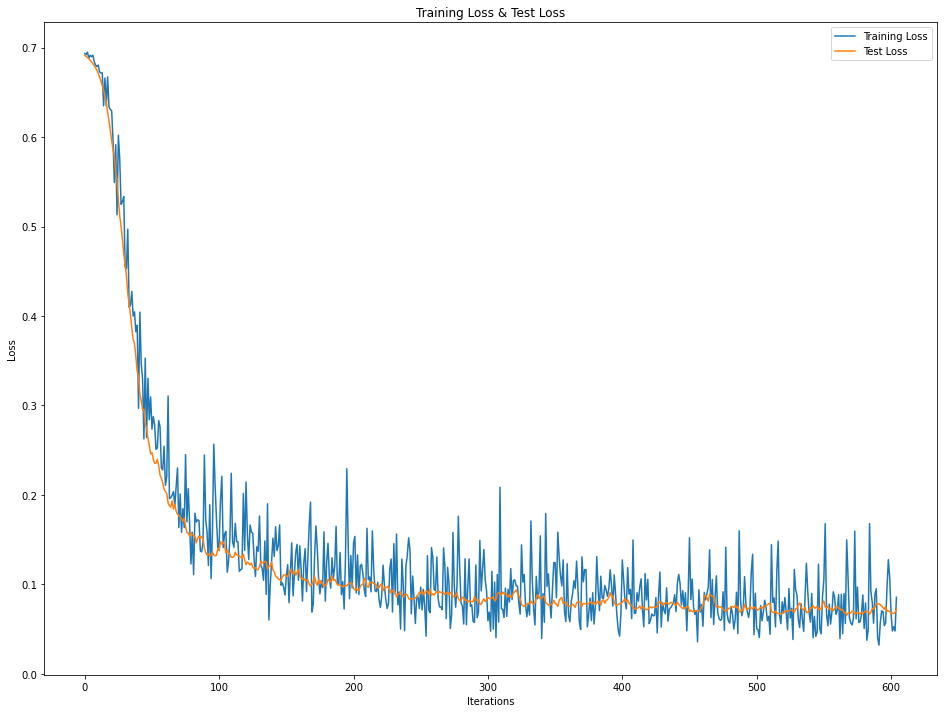

In [35]:
# Plot loss
plt.figure(figsize=[16,12])
plt.plot(training_loss)
plt.plot(test_loss)
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss & Test Loss')
plt.show()

## (e-ii)

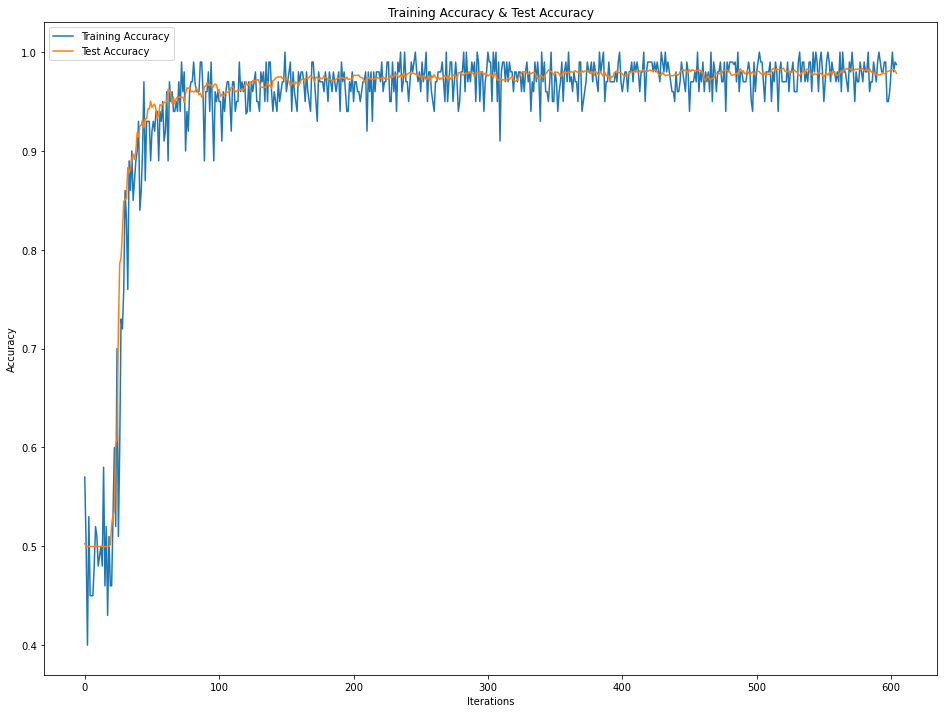

In [36]:
# Plot accuracy
plt.figure(figsize=[16,12])
plt.plot(training_accuracy)
plt.plot(test_accuracy)
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training Accuracy & Test Accuracy')
plt.show()

## (e-iii)

_Examine the images that your network guesses incorrectly, and explain at a high level what patterns you see in those images._

These wrongly classified images are carelessly written, we cannot even distinguish them by our eyes.

In [37]:
training_loss, training_accuracy, test_loss, test_accuracy, output = \
SGD(X_train, Y_train, X_test, Y_test, activations, layer_dims, batch_size, step_size, epochs)

0

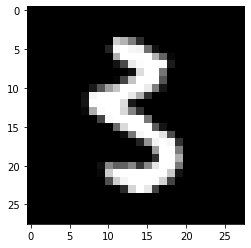

In [38]:
Y_predict = np.where(output >= 0.5, 1, 0)
X_wrong = X_test[Y_predict != Y_test]
X_wrong = X_wrong.reshape(len(X_wrong), 28, 28)
Y_wrong = Y_test[Y_predict != Y_test]
plt.imshow(X_wrong[0], cmap="gray")
# 3 is labeled as 0, 9 is labeled as 1
Y_wrong[0]

0

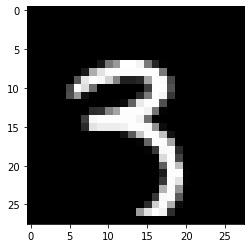

In [39]:
plt.imshow(X_wrong[1], cmap="gray")
Y_wrong[1]

0

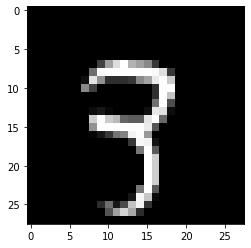

In [40]:
plt.imshow(X_wrong[2], cmap="gray")
Y_wrong[2]

1

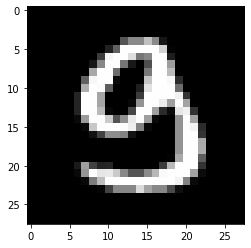

In [41]:
plt.imshow(X_wrong[3], cmap="gray")
Y_wrong[3]

1

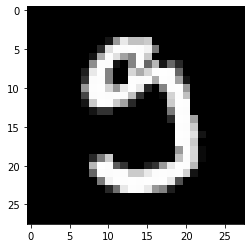

In [42]:
plt.imshow(X_wrong[4], cmap="gray")
Y_wrong[4]

## (e-iv)

In [43]:
training_loss, training_accuracy, test_loss, test_accuracy, output = \
SGD(X_train, Y_train, X_test, Y_test, activations, layer_dims, batch_size=100, step_size=10.0, epochs=5)

_Rerun the neural network training but now increase the step size to 10.0. What happens? You do not need to include plots here._

The loss increases and accuracy decreases, because the step size is too large, the neutral network cannot converge.